## Overview

In this tutorial, we will build a simple aritificial neural network (ANN), also known as multilayer perceptron (MLP) or feedforward neural network (FNN). The learning outcomes are:
1. Understand how the model is formulated mathematically;
2. Understand what is meant by training the network;
3. Experiment with more complex architectures.

## Data

We generate data from a Gaussian process with a specified covariance matrix. The details of data generation do not matter as in reality, you never know the actual data generation machanism.

**The key** here is that we want to predict $y \in R^5$ given the previous values $x\in R^{25}$.

In [1]:
import sys
import os
import matplotlib.pyplot as plt
import numpy as np

import torch
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

sys.path.insert(1, '..')
os.chdir('..')

from data_formatters.weinstock2016 import *
from dataset import TSDataset
from conf import Conf

In [2]:
# loading the config file, setting the experiment name, and the seed for random pre-processing parts (like splitting)
cnf = Conf(conf_file_path='./conf/weinstock.yaml', seed=15, exp_name="Weinstock", log=False)

In [3]:
# call the data fromatter directly
data_formatter = WeinstockFormatter(cnf)

Dropped segments: 1012
Extracted segments: 1085


In [4]:
# we are going to pass our data formatter and the config file to the TSDataset class
train_dataset = TSDataset(cnf, data_formatter, data_formatter.train_data)
val_dataset = TSDataset(cnf, data_formatter, data_formatter.val_data)
test_dataset = TSDataset(cnf, data_formatter, data_formatter.test_data)

TypeError: __init__() got an unexpected keyword argument 'split'

[1.90e+03 1.00e+00 1.50e+01 0.00e+00 4.50e+01 2.06e+02]


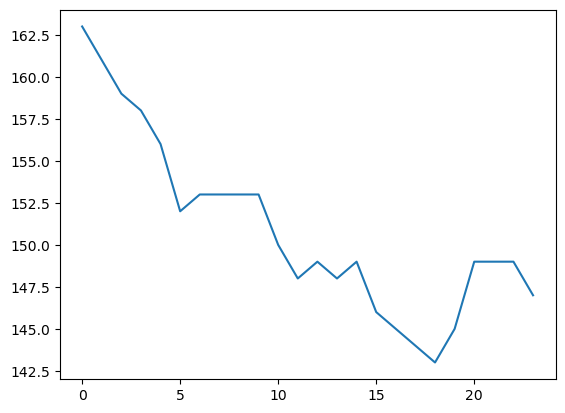

[1.9e+03 1.0e+00 2.0e+00 1.0e+01 1.5e+01 1.9e+02]


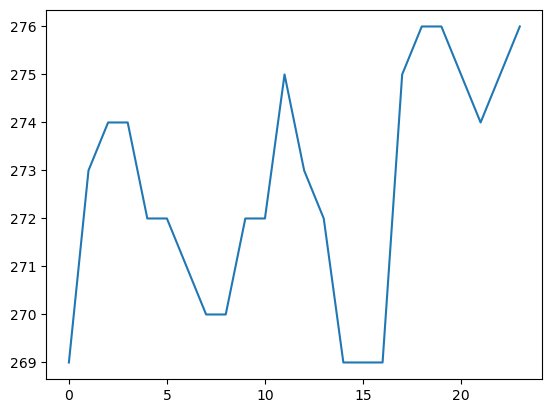

[1.9e+03 1.0e+00 3.0e+00 2.0e+00 2.5e+01 7.9e+01]


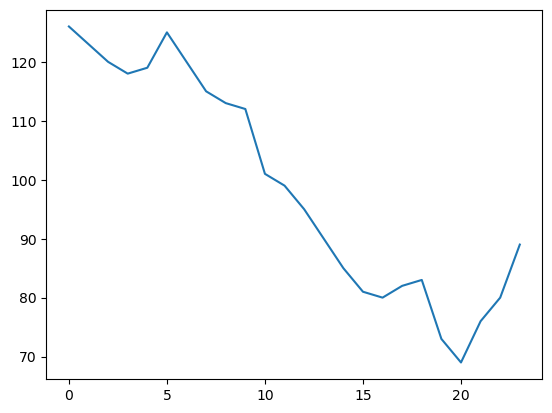

[1.90e+03 1.00e+00 3.00e+00 1.00e+00 0.00e+00 1.48e+02]


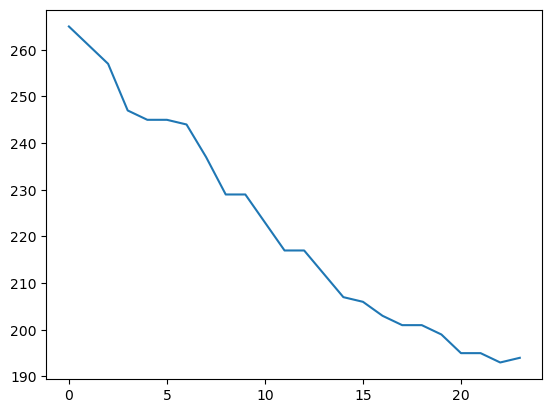

[1.90e+03 1.00e+00 1.00e+01 1.60e+01 2.00e+01 1.33e+02]


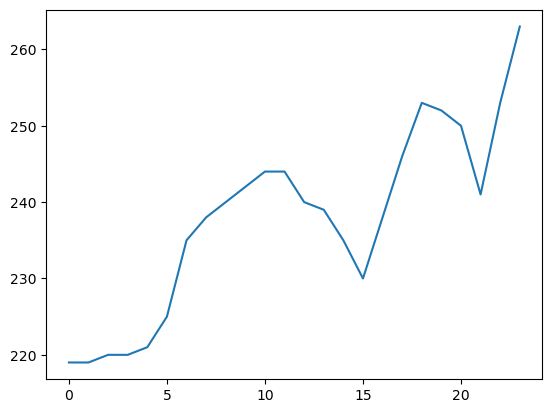

In [ ]:
for i in range(5):
    # 192 x ['power_usage', 'hour', 'day_of_week', 'hours_from_start', 'categorical_id']
    x = test_dataset[i]['inputs']
    print(x[0, :])
    # 24 x ['power_usage']
    y = test_dataset[i]['outputs']

    # plt.plot(x[:, 5])
    plt.plot(y)
    plt.show()

In [ ]:
# set up torch dataloader
from torch.utils.data import DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

## Linear regression

Suppose we want to model our data as a linear transformation, that is we aim to find $W \in R^{25\times 5}$ so that to minimize the squared error between the prediction and the truth. In summary, we formulate the problem as:
$$
W^* = \argmin_{W} || Y -  XW ||^2
$$

This model is an extension of the model many of us have covered in the introductory statisics courses to a multivariate case. **Recall** that for one-dimensional case (i.e. when $y \in R$) and under some distributional assumptions, this optimization problem has a closed form solution that is guaranteed to be the best (BLUE). When we move to more dimensions and start relaxing the assumptions, we no longer have the closed-form solution. Hence, we need to resort to the apprximate methods. Below, we program the model and see its performance.

In [ ]:
class LinearModel(torch.nn.Module):
    def __init__(self):
        super(LinearModel, self).__init__()
        self.linear_collapse = torch.nn.Linear(6, 1)
        self.linear = torch.nn.Linear(192, 24)
        
    def forward(self, x):
        y_pred = self.linear(torch.squeeze(self.linear_collapse(x)))
        return y_pred

In [ ]:
# train model
best_loss = 1e1000
model = LinearModel()
criterion = torch.nn.MSELoss(reduction='mean')
optimizer = torch.optim.SGD(model.parameters(), lr=0.000000001)
for epoch in range(10):
    # for i, (inputs, labels) in enumerate(train_loader):
    for i, d in enumerate(train_loader):
        # Forward pass
        outputs = model(d.get('inputs'))
        loss = criterion(outputs, torch.squeeze(d.get('outputs')))
        
        # Backward and optimize
        optimizer.zero_grad() # zero the gradient buffer
        loss.backward() # compute gradient
        optimizer.step() # update parameters
        
    print ('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, 100, loss.item()))
    # validate model
    with torch.no_grad():
        # for i, (inputs, labels) in enumerate(val_loader):
        for i, d in enumerate(val_loader):
            outputs = model(d.get('inputs'))
            loss = criterion(outputs, torch.squeeze(d.get('outputs')))
        print ('Epoch [{}/{}], Val Loss: {:.4f}'.format(epoch+1, 100, loss.item()))
    # save best model based on val loss
    if loss.item() < best_loss:
        best_loss = loss.item()
        torch.save(model.state_dict(), 'best_model_linear.pth')
# load best model
model.load_state_dict(torch.load('best_model_linear.pth'))

Epoch [1/100], Loss: 40425.1406
Epoch [1/100], Val Loss: 57180.1719
Epoch [2/100], Loss: 31141.2285
Epoch [2/100], Val Loss: 45961.8320
Epoch [3/100], Loss: 30697.4746
Epoch [3/100], Val Loss: 39190.9297
Epoch [4/100], Loss: 24585.5078
Epoch [4/100], Val Loss: 33399.0820
Epoch [5/100], Loss: 32821.4023
Epoch [5/100], Val Loss: 27760.5137
Epoch [6/100], Loss: 5254.7202
Epoch [6/100], Val Loss: 22460.4551
Epoch [7/100], Loss: 13499.2686
Epoch [7/100], Val Loss: 17885.6562
Epoch [8/100], Loss: 4828.0093
Epoch [8/100], Val Loss: 14382.2646
Epoch [9/100], Loss: 7010.1270
Epoch [9/100], Val Loss: 11912.9639
Epoch [10/100], Loss: 2406.6174
Epoch [10/100], Val Loss: 10311.4395
Epoch [11/100], Loss: 2763.9612
Epoch [11/100], Val Loss: 9312.2236
Epoch [12/100], Loss: 2939.6194
Epoch [12/100], Val Loss: 8704.8887
Epoch [13/100], Loss: 5113.8364
Epoch [13/100], Val Loss: 8339.5049
Epoch [14/100], Loss: 1651.9487
Epoch [14/100], Val Loss: 8121.1548
Epoch [15/100], Loss: 3588.2490
Epoch [15/100], Va

<All keys matched successfully>

In [ ]:
# evaluate model on test set
with torch.no_grad():
    for i, d in enumerate(test_loader):
        outputs = model(d.get('inputs'))
        loss = criterion(outputs, torch.squeeze(d.get('outputs')))
    print ('Epoch [{}/{}], Test Loss: {:.4f}'.format(epoch+1, 100, loss.item()))

Epoch [100/100], Test Loss: 6347.8438


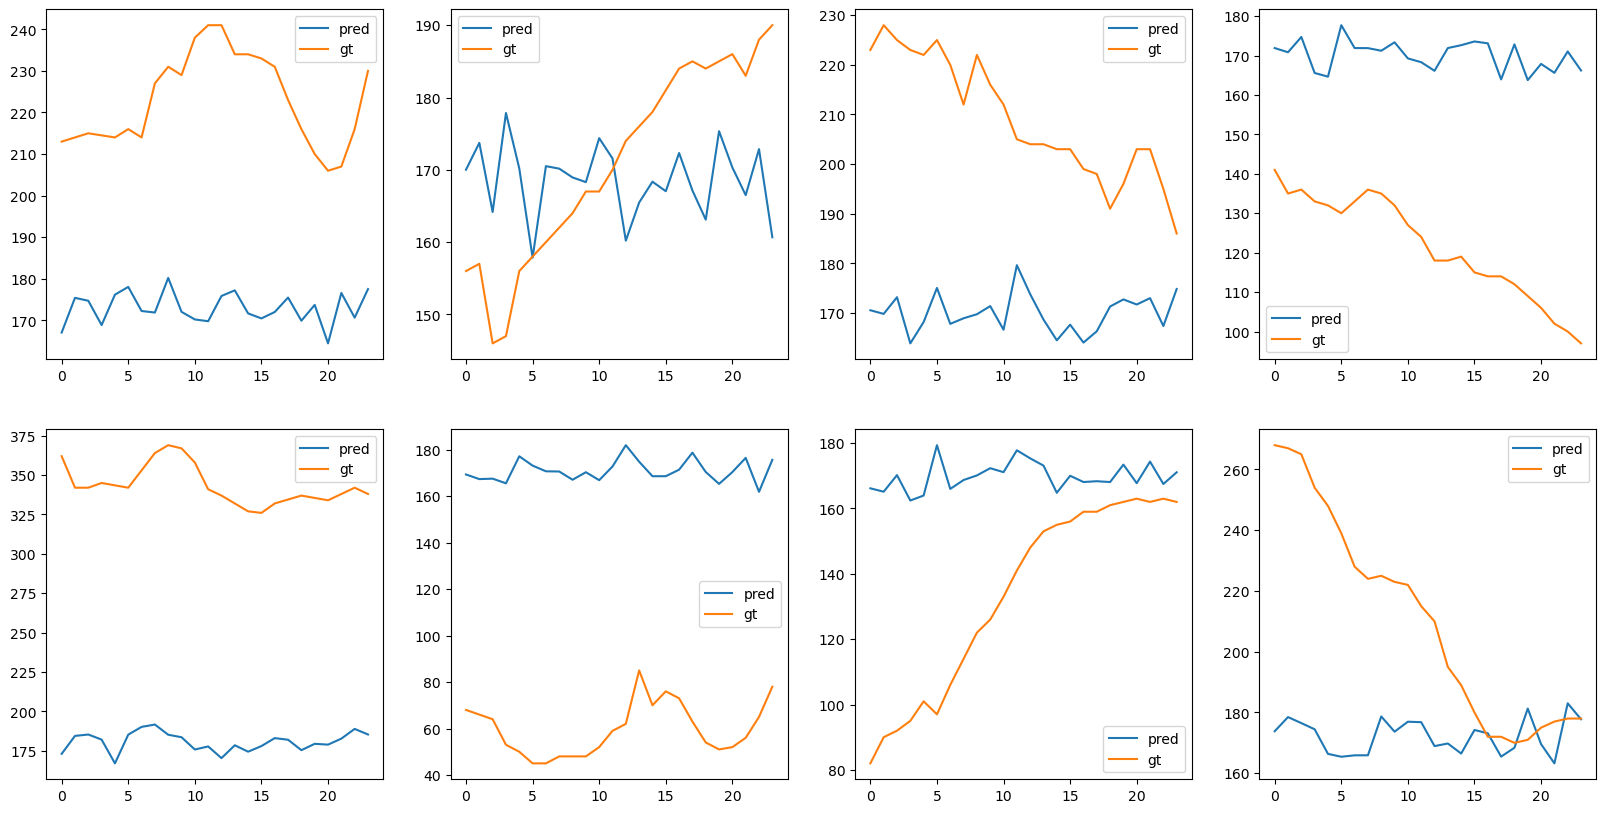

In [ ]:
# plots the predictions vs the ground truth
import matplotlib.pyplot as plt
labels = d.get('outputs')
fig, ax = plt.subplots(2, 4, figsize=(20, 10))
for i in range(2):
    for j in range(4):
        ax[i, j].plot(outputs[i*4+j, :], label='pred')
        ax[i, j].plot(labels[i*4+j, :], label='gt')
        ax[i, j].legend()

## Can we do better?

In our case, there is little justification to move beyond the linear regression setting because of how the data is generated. Nevertheless, nobody is stopping us from trying. Let's now formulate our model as: $$\hat y  = (ReLU(XW^{(1)})) W^{(2)},$$
where $W^{(1)} \in R^{25 \times n_1}, W^{(2)} \in R^{n_1 \times 5}$ are learnable weight matrie and $n_1$ is a hyper-parameter we get to choose.

The main points we want to you to notice from this example are:
1. More complex models do not mean better performance;
2. Hyper-parameter tuning is tedious;
3. **Most importantly**, we can learn any differentiable architecture with the help of SGD.

In [ ]:
# define model
class MLP(torch.nn.Module):
    def __init__(self, n1):
        super(MLP, self).__init__()
        self.linear_collapse = torch.nn.Linear(6, 1)
        self.linear = torch.nn.Linear(192, n1)
        self.relu = torch.nn.ReLU()
        self.linear2 = torch.nn.Linear(n1, 24)
        
    def forward(self, x):
        y_pred = self.linear2(self.relu(self.linear(torch.squeeze(self.linear_collapse(x)))))
        return y_pred

In [ ]:
# train model
best_loss = 1e10000
model = MLP(100)
criterion = torch.nn.MSELoss(reduction='mean')
optimizer = torch.optim.SGD(model.parameters(), lr=0.000000001)
for epoch in range(10):
    # for i, (inputs, labels) in enumerate(train_loader):
    for i, d in enumerate(train_loader):
        # Forward pass
        outputs = model(d.get('inputs'))
        loss = criterion(outputs, torch.squeeze(d.get('outputs')))
        
        # Backward and optimize
        optimizer.zero_grad() # zero the gradient buffer
        loss.backward() # compute gradient
        optimizer.step() # update parameters
        
    print ('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, 100, loss.item()))
    # validate model
    with torch.no_grad():
        # for i, (inputs, labels) in enumerate(val_loader):
        for i, d in enumerate(val_loader):
            outputs = model(d.get('inputs'))
            loss = criterion(outputs, torch.squeeze(d.get('outputs')))
        print ('Epoch [{}/{}], Val Loss: {:.4f}'.format(epoch+1, 100, loss.item()))
    # save best model based on val loss
    if loss.item() < best_loss:
        best_loss = loss.item()
        torch.save(model.state_dict(), 'best_model_mlp.pth')
# load best model
model.load_state_dict(torch.load('best_model_mlp.pth'))

Epoch [1/100], Loss: 32264.9609
Epoch [1/100], Val Loss: 45664.9961
Epoch [2/100], Loss: 47091.9336
Epoch [2/100], Val Loss: 40490.0430
Epoch [3/100], Loss: 36498.6602
Epoch [3/100], Val Loss: 36284.5938
Epoch [4/100], Loss: 14729.6758
Epoch [4/100], Val Loss: 32628.7559
Epoch [5/100], Loss: 11259.0625
Epoch [5/100], Val Loss: 29346.0000
Epoch [6/100], Loss: 21545.0957
Epoch [6/100], Val Loss: 26423.6055
Epoch [7/100], Loss: 13006.8076
Epoch [7/100], Val Loss: 23844.0137
Epoch [8/100], Loss: 29738.6484
Epoch [8/100], Val Loss: 21474.6484
Epoch [9/100], Loss: 7803.7441
Epoch [9/100], Val Loss: 19297.6191
Epoch [10/100], Loss: 8790.4062
Epoch [10/100], Val Loss: 17405.7090
Epoch [11/100], Loss: 7029.1411
Epoch [11/100], Val Loss: 15810.4424
Epoch [12/100], Loss: 11449.6797
Epoch [12/100], Val Loss: 14489.8701
Epoch [13/100], Loss: 10856.9287
Epoch [13/100], Val Loss: 13402.8232
Epoch [14/100], Loss: 8698.9326
Epoch [14/100], Val Loss: 12517.0156
Epoch [15/100], Loss: 5183.3462
Epoch [15/

<All keys matched successfully>

In [ ]:
# evaluate model on test set
with torch.no_grad():
    for i, d in enumerate(test_loader):
        outputs = model(d.get('inputs'))
        loss = criterion(outputs, torch.squeeze(d.get('outputs')))
    print ('Epoch [{}/{}], Test Loss: {:.4f}'.format(epoch+1, 100, loss.item()))

Epoch [100/100], Test Loss: 7379.4272


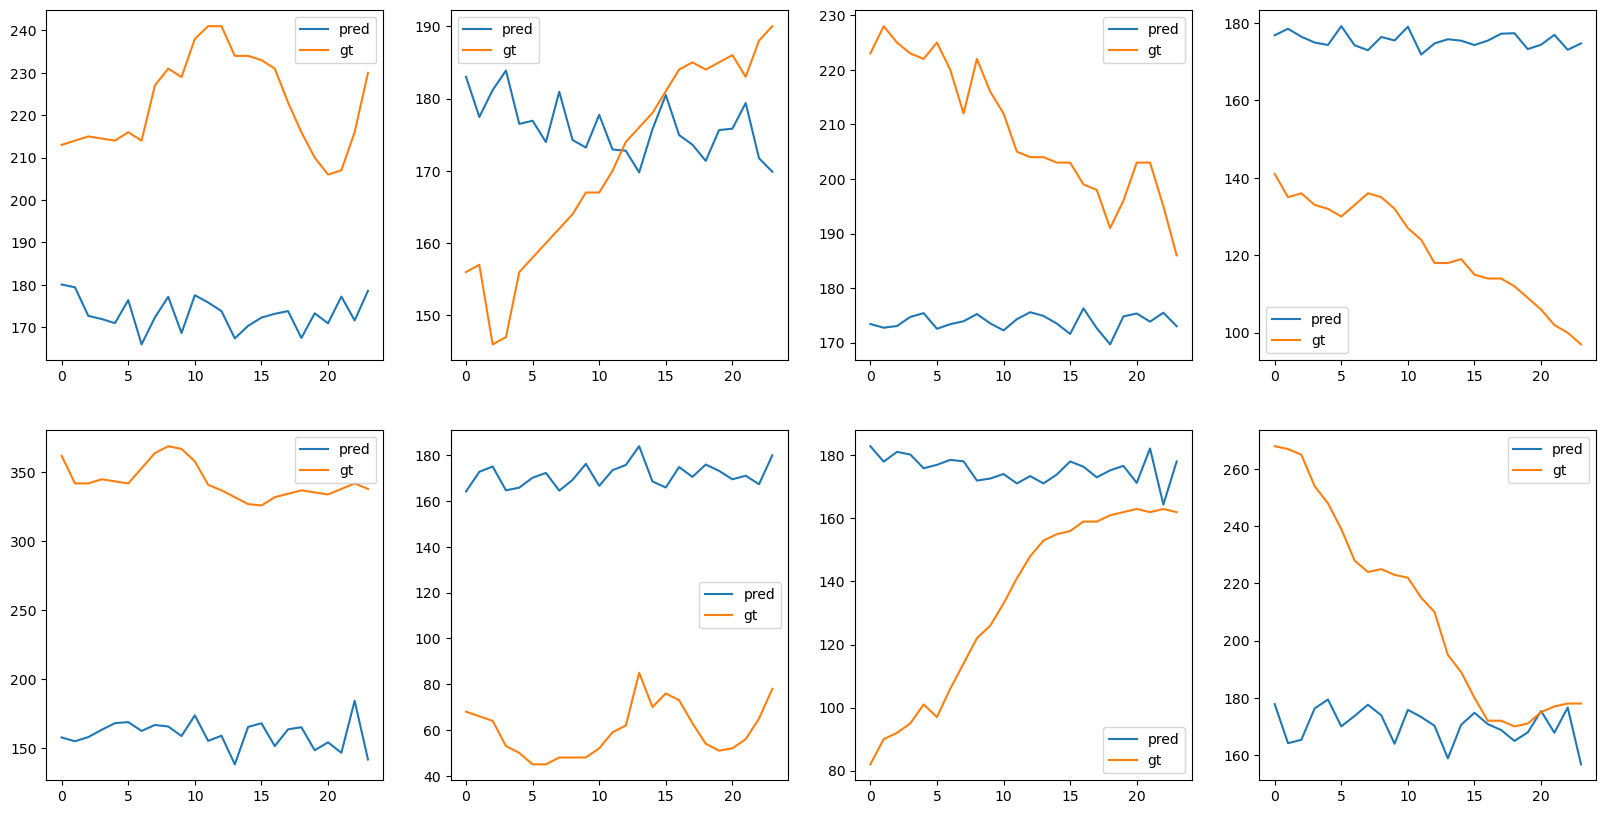

In [ ]:
# plots the predictions vs the ground truth
import matplotlib.pyplot as plt
labels = d.get('outputs')
fig, ax = plt.subplots(2, 4, figsize=(20, 10))
for i in range(2):
    for j in range(4):
        ax[i, j].plot(outputs[i*4+j, :], label='pred')
        ax[i, j].plot(labels[i*4+j, :], label='gt')
        ax[i, j].legend()